In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_table('steel_alloying.csv', sep=';', index_col=0, decimal=',')
data.head()

,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,0.456460,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,0.359285,...,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,0.331665,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,0.377945,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,0.389875,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN


In [3]:
# размер датасета
data.shape

(7041, 84)

In [4]:
# data.info()

In [5]:
# data['ПРОФИЛЬ'].value_counts() 
# Значения данного столбца скорее относятся к форме сплава, чем его сотставу. 

In [6]:
# Удаляемя не информативные признаки 
data.drop(['nplv', 'DT', 'ПРОФИЛЬ'], axis=1, inplace=True)

In [7]:
data['МАРКА'].value_counts()

Э76ХФ     4953
Э90ХАФ    1384
Э73Ф       227
Э76Ф        86
Ш2.2        59
Э76         56
R350HT      54
900А        54
Э76ХАФ      50
R260        35
G2HH        34
Ш2Л         31
НХ           7
09Г2С        4
С345         3
С255         2
С355         1
Ст3сп        1
Name: МАРКА, dtype: int64

Выборка по маркам сталей не сбалонсированная, сформируем три класса сталей Э76ХФ, Э90ХАФ и другие - объединение остальных классов.

In [8]:
# marka_dict = {'Э76ХФ': 'Э76ХФ', 'Э90ХАФ': 'Э90ХАФ', 'Э73Ф': 'Э73Ф', 'Э76Ф': 'Э76Ф', 'Ш2.2': 'Ш2.2', 'Э76': 'Э76',
#               '900А': '900А', 'R350HT': 'R350HT', 'Э76ХАФ': 'Э76ХАФ', 'R260': 'R260', 'G2HH': 'G2HH', 'Ш2Л': 'Ш2Л',
#               'НХ': 'Другие' , '09Г2С': 'Другие', 'С345': 'Другие', 'С255': 'Другие', 'С355': 'Другие', 'Ст3сп' : 'Другие'}
# data['МАРКА'] = data['МАРКА'].map(marka_dict)   

In [9]:
marka_dict = {'Э76ХФ': 'Э76ХФ', 'Э90ХАФ': 'Э90ХАФ', 'Э73Ф': 'Другие', 'Э76Ф': 'Другие', 'Ш2.2': 'Другие', 'Э76': 'Другие',
              '900А': 'Другие', 'R350HT': 'Другие', 'Э76ХАФ': 'Другие', 'R260': 'Другие', 'G2HH': 'Другие', 'Ш2Л': 'Другие',
              'НХ': 'Другие' , '09Г2С': 'Другие', 'С345': 'Другие', 'С255': 'Другие', 'С355': 'Другие', 'Ст3сп' : 'Другие'}
data['МАРКА']  = data['МАРКА'].map(marka_dict)

In [10]:
data['МАРКА'].value_counts()

Э76ХФ     4953
Э90ХАФ    1384
Другие     704
Name: МАРКА, dtype: int64

## Переменные времени

In [11]:
data.iloc[:, 1:5].describe()

,t вып-обр,t обработка,t под током,t продувка
count,6444.000000,6440.000000,6440.000000,6444.000000
mean,26.492241,46.194099,21.010523,46.063051
std,14.842045,9.878727,4.758272,9.625492
min,-1.000000,4.350000,2.816667,4.350000
25%,14.000000,42.350000,18.033333,42.216667
50%,25.000000,44.683333,20.500000,44.550000
75%,37.000000,47.550000,23.300000,47.516667
max,98.000000,294.083333,67.583333,251.000000


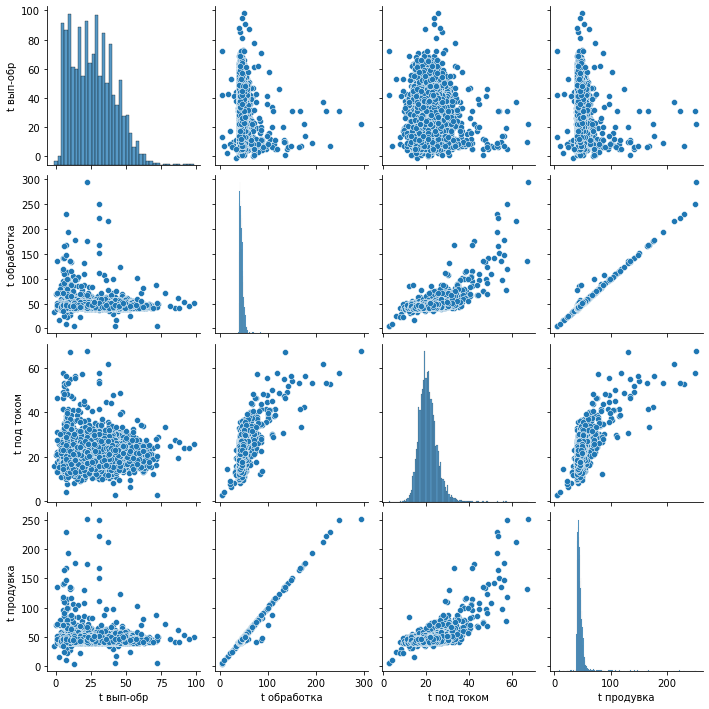

In [12]:
sns.pairplot(data.iloc[:, 1:5])

##  Удаление полупустых строчек и столбцев

### Строки

In [13]:
null_values = pd.DataFrame({'кол-во пропуск' :data.iloc[:, :].isna().sum()})
null_values['per'] = (null_values.iloc[:, 0] * 100 / len(data)).apply(lambda x: round(x, 2))
null_values.value_counts().head(5) # количесвто колонок, в которых одинаковое кол-во пропусков

кол-во пропуск  per  
597             8.48     37
598             8.49      4
601             8.54      4
2299            32.65     4
5652            80.27     2
dtype: int64

In [14]:
# Проверяем, что в 37 колонках, в которых отстутвует 597 значений, пропуски относятся к одним и тем же строкам.
empty_columns = data[null_values[null_values.per == 8.48].index].T.isna().sum() 
(empty_columns == 37).sum()

597

In [15]:
data[null_values[null_values.per == 8.48].index].columns
# в этих строках отутсвуют основные переменные, по которым мы анализуем наши данные (химшлак последний CaO, FeO, MnO, R)
# значит можем эти строки удалять

Index(['t вып-обр', 't продувка', 'произв жидкая сталь',
       'произв количество обработок', 'произв  количество плавок',
       'произв количество плавок (цел)', 'химсталь первый Al_1',
       'химсталь первый C_1', 'химсталь первый Cr_1', 'химсталь первый Cu_1',
       'химсталь первый Mn_1', 'химсталь первый Ni_1', 'химсталь первый P_1',
       'химсталь первый S_1', 'химсталь первый Si_1', 'химсталь первый Ti_1',
       'химсталь первый V_1', 'химсталь последний Al', 'химсталь последний C',
       'химсталь последний Cr', 'химсталь последний Cu',
       'химсталь последний Mn', 'химсталь последний Mo',
       'химсталь последний Ni', 'химсталь последний P', 'химсталь последний S',
       'химсталь последний Si', 'химсталь последний Ti',
       'химсталь последний V', 'химшлак первый CaO_1', 'химшлак первый FeO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MnO',
       'химшлак последний R'],
  

In [16]:
data.drop(empty_columns[empty_columns == 37].index, axis=0, inplace=True)
data.shape

(6444, 81)

### Столбцы

In [17]:
def df_null_values(df):
    null_values = pd.DataFrame({'кол-во пропуск' :df.isna().sum()})
    null_values['per'] = (null_values.iloc[:, 0] * 100 / len(df)).apply(lambda x: round(x, 3))
    return null_values

In [18]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(17)

,кол-во пропуск,per
ферспл FeSi-75,6439,99.922
сыпуч кокс. мелочь (сух.),6437,99.891
сыпуч кварцит,6431,99.798
ферспл FeMo,6411,99.488
ферспл Ni H1 пласт.,6362,98.727
ферспл FeV азот.,6061,94.056
расход C пров.,5720,88.765
ферспл ферванит,5427,84.218
N2 (интенс.),5055,78.445
расход газ N2,5055,78.445


In [19]:
#удалим колонки, в которых больше 70 % пропусков 
data.drop(null_values[null_values.per > 70].index, axis=1, inplace=True)
data.shape

(6444, 71)

# Восстановление пропущенных значений

In [20]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(7)

,кол-во пропуск,per
химшлак последний SiO2,1702,26.412
химшлак последний Al2O3,1702,26.412
химшлак первый Al2O3_1,1702,26.412
химшлак первый SiO2_1,1702,26.412
сыпуч известь РП,1674,25.978
ПСН гр.,1195,18.544
чист расход Cr,561,8.706


Для химшлаков SiO2 и Al2O3 неизветно 26.4 % процентов данны, а они целевые переменные. Помотрим с какими переменными они коррелеруют.

In [21]:
# проверка, что нет  данных по одним и тем же строчкам
(data['химшлак последний SiO2'].isna() == data['химшлак первый Al2O3_1'].isna()).sum()

6444

## Корреляция между переменными химшлаков

<AxesSubplot:>

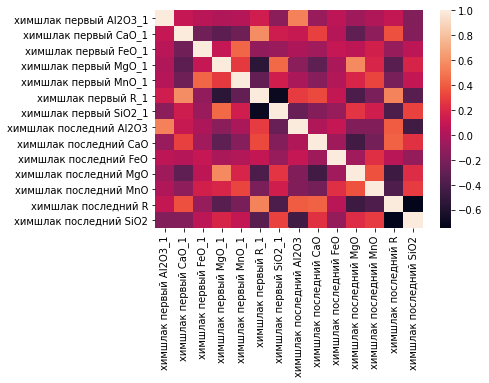

In [22]:
corr_for_target = data[['химшлак первый Al2O3_1',
       'химшлак первый CaO_1', 'химшлак первый FeO_1', 'химшлак первый MgO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак первый SiO2_1',
       'химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']].corr()
sns.heatmap(corr_for_target)

In [23]:
# Проверим, что коэффиценты корреляции по модулю больше 1.5 статистически значимы
columns = ['химшлак первый Al2O3_1',
       'химшлак первый CaO_1', 'химшлак первый FeO_1', 'химшлак первый MgO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак первый SiO2_1',
       'химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']
real_corr = []
for k, i in enumerate(columns):
    for j in columns[k + 1:]:
        df = data[[i, j]].dropna()
        corr = pearsonr(df[i].to_numpy(), df[j])
        if  (corr[1] > 0.05) and (corr[0] > 0.15) :  
            print(i , j, corr)

### Наибольшие коэффиценты корреляции между переменными химшлаков

In [24]:
target_name = []
target_corr = []
corr = []
for name in columns:
    df = np.abs(corr_for_target[name]).sort_values(ascending=False)
    target_name.append(name)
    target_corr.append(df.index[1])
    corr.append(round(corr_for_target.loc[name, df.index[1]], 3))
target_corr_df = pd.DataFrame({'target' : target_name, 'corr_target': target_corr, 'corr' : corr})
target_corr_df

,target,corr_target,corr
0,химшлак первый Al2O3_1,химшлак последний Al2O3,0.540
1,химшлак первый CaO_1,химшлак первый R_1,0.591
2,химшлак первый FeO_1,химшлак первый MnO_1,0.438
3,химшлак первый MgO_1,химшлак последний MgO,0.572
4,химшлак первый MnO_1,химшлак первый FeO_1,0.438
5,химшлак первый R_1,химшлак первый SiO2_1,-0.702
6,химшлак первый SiO2_1,химшлак первый R_1,-0.702
7,химшлак последний Al2O3,химшлак первый Al2O3_1,0.540
8,химшлак последний CaO,химшлак последний MgO,-0.440
9,химшлак последний FeO,химшлак последний MnO,0.240


Из таблицы выше видно, что химшлаки SiO2 можно восстановить по химшлакам R, однако наибольние коэффиценты корреляции у химшлаков Al2O3 между собой, значит для восстановления будем использовать следующий химшлак с сильной линейной зависимостью.

In [27]:
def brief_summary(series):
    print(series.name, '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(series.mean(), 3),\
                                                                         round(series.std(), 3),\
                                                                         series.median()))

In [28]:
for target in ['химшлак последний SiO2', 'химшлак первый SiO2_1']:
    print('До:')
    brief_summary(data[target])
    target_line = target_corr_df[target_corr_df.target == target]
    X = data[target_line.iloc[0, 1]]
    Y = data[target]
    x_train = X[~Y.isna()].to_numpy().reshape(-1, 1)
    y_train = Y[~Y.isna()]
    x_test = X[Y.isna()].to_numpy().reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    data[target][Y.isna()] = lr.predict(x_test)
    print('После:')
    brief_summary(data[target])
    
for target, corr_target in zip(['химшлак первый Al2O3_1',  'химшлак последний Al2O3'] ,[ 'химшлак первый R_1', 'химшлак последний R']):
    print('До:')
    brief_summary(data[target])
    X = data[corr_target]
    Y = data[target]
    x_train = X[~Y.isna()].to_numpy().reshape(-1, 1)
    y_train = Y[~Y.isna()]
    x_test = X[Y.isna()].to_numpy().reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    data[target][Y.isna()] = lr.predict(x_test)
    print('После:')
    brief_summary(data[target])

До:
химшлак последний SiO2 
Медиана: 24.4, Среднее значение: 23.972, Ср.откл:2.188
После:
химшлак последний SiO2 
Медиана: 24.490132729267934, Среднее значение: 24.043, Ср.откл:2.056
До:
химшлак первый SiO2_1 
Медиана: 22.7, Среднее значение: 22.705, Ср.откл:2.394
После:
химшлак первый SiO2_1 
Медиана: 22.777099396938347, Среднее значение: 22.702, Ср.откл:2.236
До:
химшлак первый Al2O3_1 
Медиана: 4.0, Среднее значение: 4.114, Ср.откл:0.928
После:
химшлак первый Al2O3_1 
Медиана: 4.067639924715721, Среднее значение: 4.114, Ср.откл:0.799
До:
химшлак последний Al2O3 
Медиана: 4.5, Среднее значение: 4.598, Ср.откл:0.96
После:
химшлак последний Al2O3 
Медиана: 4.474126828157326, Среднее значение: 4.581, Ср.откл:0.848


Видим, что заполнение пустых значений не сильно изменило параметры распредлений данных химшлаков 

In [29]:
data.isna().sum().sort_values()

МАРКА                      0
химшлак последний R        0
химсталь первый Ni_1       0
химсталь первый P_1        0
химсталь первый S_1        0
                        ... 
сыпуч  шпат плав.        534
ферспл  фх850А           561
чист расход Cr           561
ПСН гр.                 1195
сыпуч известь РП        1674
Length: 71, dtype: int64

## Восстановление пропущенных значений

In [30]:
def description(df, columns):
    for name in columns:
        print(name, '\nПропущенных значений:', df[name].isna().sum(),\
              '(', round(df[name].isna().sum() * 100 / len(df[name]), 2)  ,'%)',
             '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(df[name].mean(), 3),\
                                                                         round(df[name].std(), 3),\
                                                                         df[name].median()),\
              '\nУникальных значений: {}'.format(df[name].value_counts(dropna=False).count()), '\n')
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(221)
        plt.hist(df[name])
        plt.grid()
        plt.subplot(222)
        sns.boxplot(y=df[name])
        plt.show()

In [31]:
data.shape

(6444, 71)

In [32]:
null_values = df_null_values(data)
data_with_nan = null_values[null_values.per != 0].sort_values('per', ascending = False)
data_with_nan

,кол-во пропуск,per
сыпуч известь РП,1674,25.978
ПСН гр.,1195,18.544
чист расход Cr,561,8.706
ферспл фх850А,561,8.706
сыпуч шпат плав.,534,8.287
чист расход V,266,4.128
ферспл FeV-80,265,4.112
химсталь последний Ca,226,3.507
ферспл CaC2,200,3.104
сыпуч кокс. мелочь КМ1,137,2.126


In [33]:
df_first = data.copy()

## сыпуч известь РП

У данной переменной 26 % пропущенных значений. Попробуем восстановить их через внутриклассовые медианы значений

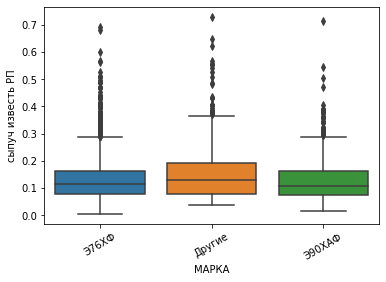

In [34]:
ax = sns.boxplot(data=df_first, y='сыпуч известь РП' , x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);


Распределние не симметричное, с длинным правым хвостом, попробуем прологарифмировать эти значения, чтобы получить более симметричное распределение.

In [35]:
df_first['ln сыпуч известь РП'] = np.log(df_first['сыпуч известь РП'])

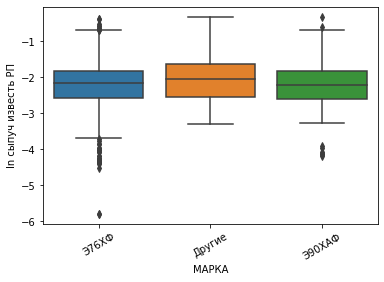

In [36]:
ax = sns.boxplot(data=df_first, y='ln сыпуч известь РП', x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [37]:
name = 'ln сыпуч известь РП' 
grouped = df_first[['МАРКА', name]].groupby('МАРКА')
CaO_ln = grouped[name].transform(lambda x: x.fillna(x.median()))

Посмотрим как изменится распределение "сыпуч известь РП" после подстановки пропущенных значений

In [38]:
brief_summary(np.exp(CaO_ln))

ln сыпуч известь РП 
Медиана: 0.116, Среднее значение: 0.128, Ср.откл:0.069


In [39]:
brief_summary(data['сыпуч известь РП'])

сыпуч известь РП 
Медиана: 0.11599999999999999, Среднее значение: 0.132, Ср.откл:0.08


In [40]:
# Пармаметры распредления почти не изменились. Все ок
data['сыпуч известь РП'] = np.exp(CaO_ln)

In [41]:
data.isna().sum().sort_values(ascending=False)

ПСН гр.                 1195
ферспл  фх850А           561
чист расход Cr           561
сыпуч  шпат плав.        534
чист расход V            266
                        ... 
химсталь первый S_1        0
химсталь первый P_1        0
химсталь первый Ni_1       0
химшлак последний R        0
МАРКА                      0
Length: 71, dtype: int64

## ПСН гр. 

In [42]:
data[['ПСН гр.', 'эл. энергия (интенс.)']].corr()

,ПСН гр.,эл. энергия (интенс.)
ПСН гр.,1.000000,0.459081
эл. энергия (интенс.),0.459081,1.000000


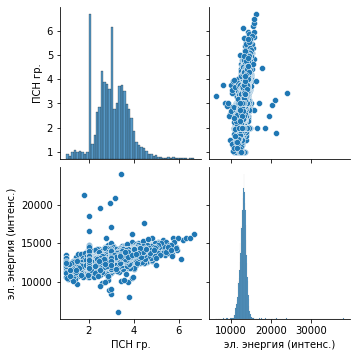

In [43]:
sns.pairplot(data[['ПСН гр.', 'эл. энергия (интенс.)']])

ПСН гр. хорошо коррелирует с "эл. энергия (интенс.)"

Удалим "ПСН гр." из датасета, так как он не очень информативен

In [44]:
data.drop('ПСН гр.', axis=1, inplace=True)

In [45]:
null_values = df_null_values(data)
data_with_nan = null_values[null_values.per != 0].sort_values('per', ascending = False)
data_with_nan.head(5)

,кол-во пропуск,per
ферспл фх850А,561,8.706
чист расход Cr,561,8.706
сыпуч шпат плав.,534,8.287
чист расход V,266,4.128
ферспл FeV-80,265,4.112


### Переменные: чист расход Cr, сыпуч  шпат плав., ферспл  фх850А

In [46]:
num_line_by_marka = data['МАРКА'].value_counts().sort_index()

In [47]:
Cr_nan = pd.DataFrame({'marka': data['МАРКА'], 'Cr': data['чист расход Cr'].isna(),'fx850': data['ферспл  фх850А'].isna(),
                      'сыпуч  шпат плав.': data[ 'сыпуч  шпат плав.'].isna() }).groupby('marka')[['Cr','fx850', 'сыпуч  шпат плав.']].sum().sort_index()
Cr_nan
check_with_Cr = pd.DataFrame({'Cr_nan': Cr_nan.Cr, 'fx850_nan' : Cr_nan.fx850, 'num_line_in_makr' : num_line_by_marka, 'сыпуч  шпат плав.': Cr_nan['сыпуч  шпат плав.'] })
check_with_Cr

,Cr_nan,fx850_nan,num_line_in_makr,сыпуч шпат плав.
marka,,,,
Другие,543,543,666,103
Э76ХФ,15,15,4432,316
Э90ХАФ,3,3,1346,115


In [48]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.048, Среднее значение: 0.055, Ср.откл:0.024


In [49]:
data['сыпуч  шпат плав.'].fillna(0, inplace=True)

In [50]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.047, Среднее значение: 0.05, Ср.откл:0.027


In [51]:
 data[['МАРКА', 'чист расход Cr']].groupby('МАРКА').agg(['mean', 'median', 'std'])

чист расход Cr                    
                 mean    median       std
МАРКА                                    
Другие       0.127993  0.117738  0.071761
Э76ХФ        0.125202  0.125840  0.027272
Э90ХАФ       0.092049  0.092518  0.024586

In [52]:
brief_summary(data['чист расход Cr'])
grouped = data[['МАРКА', 'чист расход Cr']].groupby('МАРКА')
data['чист расход Cr'] = grouped['чист расход Cr'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['чист расход Cr'])

чист расход Cr 
Медиана: 0.11877, Среднее значение: 0.118, Ср.откл:0.032
чист расход Cr 
Медиана: 0.11773800000000001, Среднее значение: 0.118, Ср.откл:0.03


In [53]:
 data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА').agg(['mean', 'median', 'std'])

ферспл  фх850А                 
                 mean median       std
МАРКА                                 
Другие       0.225358  0.206  0.126888
Э76ХФ        0.221376  0.223  0.048403
Э90ХАФ       0.162588  0.163  0.043999

In [54]:
brief_summary(data['ферспл  фх850А'])
grouped = data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА')
data['ферспл  фх850А'] = grouped['ферспл  фх850А'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['ферспл  фх850А'])

ферспл  фх850А 
Медиана: 0.21, Среднее значение: 0.208, Ср.откл:0.056
ферспл  фх850А 
Медиана: 0.20600000000000002, Среднее значение: 0.208, Ср.откл:0.054


## Остальные пропущенные значения заполним медианами

In [55]:
df = data.isna().sum().sort_values(ascending=False)
df = df[df != 0]
df
data.dropna(axis=0, subset=['химшлак первый MgO_1', 'химшлак последний MgO'], inplace=True)

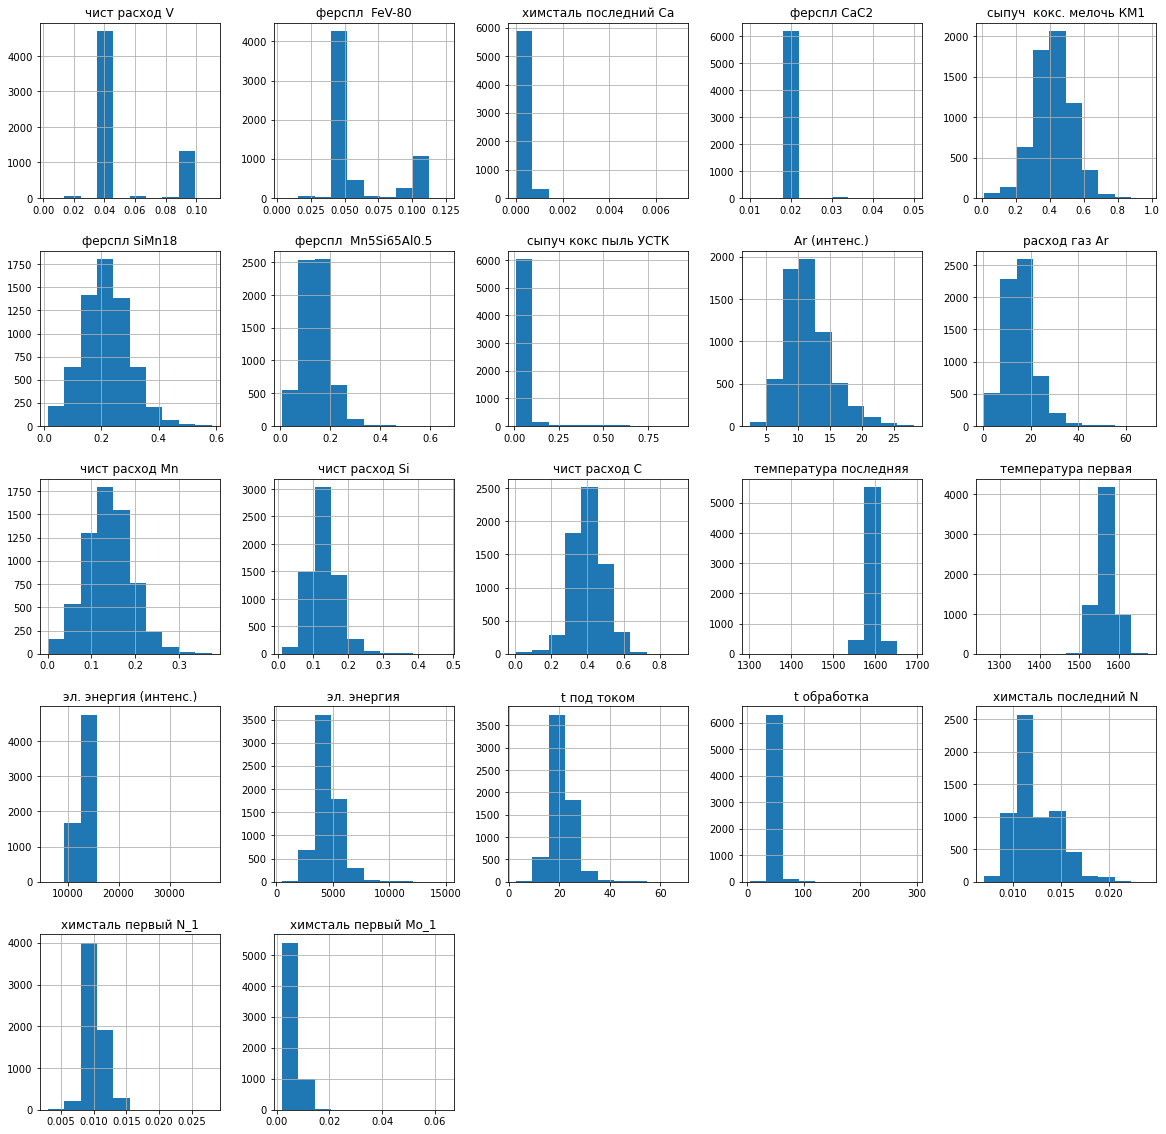

In [56]:
df = data.isna().sum().sort_values(ascending=False)
df = df[df != 0]
data[df.index].hist(figsize=(20,20));

In [57]:
data[df.index] = data[df.index].apply(lambda x : x.fillna(x.median()))

### Удаление неинформативных признаков

In [58]:
# Нормирование и вариативность признаков
scaler = StandardScaler()
scaler.fit(data.iloc[:,1:])
feature_selection = scaler.transform(data.iloc[:,1:])
# data.iloc[:, 1: ] = feature_selection
std_df = pd.DataFrame(feature_selection, columns=data.iloc[:, 1:].columns).std()
std_df.sort_values(ascending=True)

произв количество плавок (цел)    0.000000
произв  количество плавок         0.000000
сыпуч кокс пыль УСТК              1.000078
химсталь первый Ti_1              1.000078
химсталь первый V_1               1.000078
                                    ...   
химшлак последний FeO             1.000078
химсталь последний Mo             1.000078
химсталь последний Ti             1.000078
произв количество обработок       1.000078
ферспл CaC2                       1.000078
Length: 69, dtype: float64

In [59]:
data.drop(['произв количество плавок (цел)', 'произв  количество плавок'], inplace=True, axis=1)

In [60]:
data.shape

(6443, 68)

### Из (7041, 84) значений у нас осталось (6443, 68)

1. Из 18 марок сталей сформировали 3 класса: Э76ХФ, Э90ХАФ и другие - объединение остальных классов, чтобы сделать более сбалансированную выборку

2. Удалили неинформативные признаки и признаки с более 70 % пропусками

3. Мы удалили 598 элементов, 597 из них - это строки, в которых остуствовали значений 37 признаков, включая целевые переменны. Еще один элемент не имел значения по химпшлаку MnO.

4. В итоге у химшлаков AL2O3 и SiO отсутсвовало 26 %. Восстановили их с помощью химшлака R, так как наблюдаетя линейная зависимость. 

5. 'Cыпуч известь РП' и 'ПСН гр.' не было 25 % данных. 'ферспл фх850А, чист расход Cr, 'сыпуч шпат плав.' не было 8 % данных.	 Восстановили их с помощью внутриклассовой медианы по маркам. Остальные восстановили медианой признака.

## Выбросы

In [61]:
# удаление выбросов
out_forest = IsolationForest()
out_forest.fit(data.iloc[:, 1:])
outlier_predicted = out_forest.predict(data.iloc[:, 1:])
ready_df = data[outlier_predicted == 1].copy()
ready_df.shape

(6195, 68)

In [62]:
(outlier_predicted == 1).sum()

6195

## Отбор признаков

In [63]:
ready_df = data.copy()
ready_df.shape

(6443, 68)

In [64]:
target = ready_df[['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']]
X = ready_df.drop(['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2'], axis=1)

scaler = StandardScaler()
scaler.fit(X.iloc[:, 1:])
feature_selection = scaler.transform(X.iloc[:,1:])
X.iloc[:, 1:] = feature_selection

In [67]:
target.to_csv('target_data')

<AxesSubplot:>

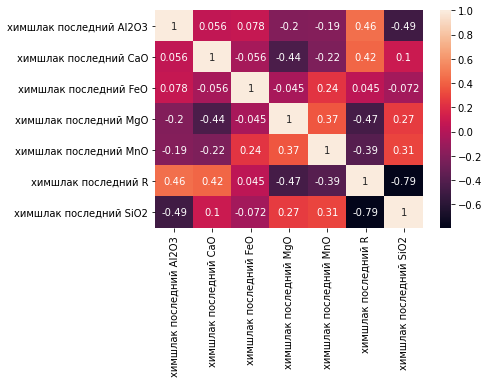

In [68]:
sns.heatmap(target.corr(), annot=True)

химшлак последний Al2O3, химшлак последний SiO2 мы дополняли, поэтому использовать их для обучения не самый лучший вариант

Al2O3 <- R (corr = 0.46)

SiO2 <- R (corr = -0.79)

CaO <- MgO <- R // CaO <- MgO (corr = -0.44), MgO <- R (corr = -0.47)

FeO <- MnO <- R //  FeO <- MnO (corr = 0.24), MgO <- R (corr = -0.39)

#### Поэтому изначально наша целевая переменная химшлак R

In [69]:
y = ready_df['химшлак последний R'] 

In [70]:
X.shape

(6443, 61)

In [71]:
X = pd.get_dummies(X)
X.head()

,t вып-обр,t обработка,t под током,t продувка,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,...,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,МАРКА_Другие,МАРКА_Э76ХФ,МАРКА_Э90ХАФ
0,0.169080,-0.083671,0.712904,-0.522521,0.585533,-1.925527,-0.410057,-0.625557,-0.457474,-0.466264,...,0.093636,1.819940,0.553765,-2.228470,-0.353759,0.553238,-0.418327,0,1,0
1,-0.033057,-0.215307,-1.501740,-0.207385,-0.480940,-1.125049,0.414180,-0.490570,-0.496740,1.437911,...,-0.108915,0.788105,0.132309,-1.892308,-0.289082,-0.642907,0.486205,0,1,0
2,-0.167814,-0.287876,-0.643215,-0.281840,-0.784063,-1.199512,-0.127848,0.225792,-0.426059,1.091698,...,0.093636,0.688890,0.132309,-0.855807,-0.353759,0.553238,-0.418327,0,1,0
3,-0.639466,-0.000977,-0.250746,0.012517,-0.276151,0.513139,1.564590,0.840108,-0.406444,0.918591,...,-0.007640,1.046063,-0.429633,-1.472104,-0.386098,-0.044835,0.033939,0,1,0
4,-0.437329,0.233605,-0.835945,0.253198,-0.145222,-0.417650,0.576006,0.302539,-0.456170,1.264805,...,-0.007640,1.006378,-0.008177,-1.948335,-0.353759,-0.044835,0.033939,0,1,0


In [72]:
lg_R = LinearRegression()
cross_val_score(lg_R, X, y, cv=5).mean()

0.27698373591349557

In [73]:
lg_R = LinearRegression()
cross_val_score(lg_R, X, y, scoring='neg_mean_squared_error',cv=5).mean()

-0.03439997552853633

In [74]:
#По результат линейной регрессии определяем, 
# какой порог коэффицента корреляция выбрать для удаления линейно зависимых признаков

# for C in np.linspace(0.5, 1, 11):
#     temp_df = abs(X.iloc[:, :-3].corr()) > C
#     maybe_remove_col = []
#     for k, i in enumerate(temp_df.columns.to_list()):
#         for j in temp_df.columns.to_list()[k + 1 :]:
#             if temp_df.loc[j, i] :
#     #             print(i, j)
#                 maybe_remove_col.append(i)
#     maybe_remove_col = set(maybe_remove_col)
#     print('\nудалим', len(maybe_remove_col), 'признаков')

#     lg_R = LinearRegression()
#     print('корреляция ', C , 'r2:', round(cross_val_score(lg_R, X.drop(maybe_remove_col, axis=1),\
#                                                                y, scoring='r2', cv=5).mean(), 4))

In [75]:
features_corr = X.iloc[:, :-3].corr()
temp_df = abs(features_corr) > 0.95
maybe_remove_col = []
for k, i in enumerate(temp_df.columns.to_list()):
    for j in temp_df.columns.to_list()[k + 1 :]:
        if temp_df.loc[j, i] :
#             print(i, j, round(features_corr.loc[j, i], 2))
            maybe_remove_col.append(i)
maybe_remove_col = set(maybe_remove_col)
print('Выбрали пороговое значеие корреляции:', 0.9, '\nудалим', len(maybe_remove_col), 'признаков')
print(maybe_remove_col)
lg_R = LinearRegression()
print('r2:', round(cross_val_score(lg_R, X.drop(maybe_remove_col, axis=1), y, scoring='r2', cv=5).mean(),4))

Выбрали пороговое значеие корреляции: 0.9 
удалим 9 признаков
{'химсталь первый P_1', 'химсталь первый Cr_1', 't обработка', 'чист расход Mn', 'химсталь первый Ni_1', 'чист расход Cr', 't под током', 'химсталь первый Cu_1', 'чист расход V'}
r2: 0.2763


In [76]:
X_without_ld = X.drop(maybe_remove_col, axis=1)
X_without_ld.shape

(6443, 54)

In [77]:
X.to_csv('features_data')
X_without_ld.to_csv('features_data_without_ld')

In [78]:
def brief_summary(series):
    print('Медиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(series.mean(), 3),\
                                                                         round(series.std(), 3),\
                                                                         round(np.median(series),3)))

lg_R = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
lg_R.fit(x_train, y_train)
y_pr = lg_R.predict(x_test)
print('mse:', round(mean_squared_error(y_pr,y_test), 4))
print('\nхимшлак R предсказанный')
brief_summary(y_pr)
print('\nхимшлак R initial')
brief_summary(y_test)


mse: 0.0341

химшлак R предсказанный
Медиана: 2.366, Среднее значение: 2.37, Ср.откл:0.15

химшлак R initial
Медиана: 2.3, Среднее значение: 2.363, Ср.откл:0.224


In [79]:
lg_R = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(X_without_ld, y, train_size=0.75)
lg_R.fit(x_train, y_train)
y_pr = lg_R.predict(x_test)
print('mse:', round(mean_squared_error(y_pr,y_test), 4))
print('\nхимшлак R предсказанный')
brief_summary(y_pr)
print('\nхимшлак R initial')
brief_summary(y_test)

mse: 0.0346

химшлак R предсказанный
Медиана: 2.351, Среднее значение: 2.362, Ср.откл:0.146

химшлак R initial
Медиана: 2.3, Среднее значение: 2.363, Ср.откл:0.223
